In [1]:
import pandas as pd
import numpy as np
import ast
import os

# 多步法按batch合并数据

In [12]:
model_list = ['vit_b_16', 'resnet50', 'vgg16']
data_root = './data_stage3/multi_step_total100_1016'
save_result_file = 'result_multi_step_total100_1016.xlsx'

In [ ]:
data1 = pd.read_excel(os.path.join(data_root, f'{model_list[0]}', f'{model_list[0]}_{save_result_file}'))
data2 = pd.read_excel(os.path.join(data_root, f'{model_list[1]}', f'{model_list[1]}_{save_result_file}'))
data3 = pd.read_excel(os.path.join(data_root, f'{model_list[2]}', f'{model_list[2]}_{save_result_file}'))
print(data1.shape)
print(data2.shape)
print(data3.shape)

In [18]:
def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr', 'channel_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    li = ['model', 'algo', 'alpha', 'mask_mode', 'step', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
        'batch_pictures': 'sum'
    }).reset_index()
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    # 将'loss'列命名为'attack_loss'
    data_grouped = data_grouped.rename(columns={'loss': 'attack_loss'})
    return data_grouped

In [19]:
data1_grouped = merge_batch_onestep(data1)
data2_grouped = merge_batch_onestep(data2)
data3_grouped = merge_batch_onestep(data3)

In [ ]:
data3_grouped.head()

In [ ]:
data_grouped = pd.concat([data1_grouped, data2_grouped, data3_grouped], axis=0)
print(data_grouped.shape)
data_grouped.head()

In [22]:
data_grouped.to_excel(os.path.join(data_root, save_result_file), index=False)

In [ ]:
# 按 li 列进行分组，并只保留 step 为 0 和 step 最大的数据
li = ['model', 'algo', 'alpha', 'mask_mode', 'parameter', 'eta']
def filter_steps(group):
    return group[(group['step'] == 0) | (group['step'] == group['step'].max())]

df_filtered = data_grouped.groupby(li).apply(filter_steps).reset_index(drop=True)
print(df_filtered.shape)
df_filtered.head()

In [24]:
df_filtered.to_excel(os.path.join(data_root, f'filtered_{save_result_file}'), index=False)

# 结果分析

In [ ]:
data_grouped = pd.read_excel('./data_stage3/multi_step_total100_1016/result_multi_step_total100_1016.xlsx')
data_grouped.head()

In [4]:
df_filtered = pd.read_excel('./data_stage3/multi_step_total100_1016/filtered_result_multi_step_total100_1016.xlsx')

In [ ]:
for column in df_filtered.columns:
    if column not in ('l1_norm', 'l2_norm', 'success_rate', 'run_time', 'step', 'pred_loss', 'attack_loss'):
        unique_values = df_filtered[column].unique()
        print(f"字段 '{column}' 的唯一值: {unique_values}")
print(df_filtered.columns)

# 画图分析

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import math
from sklearn.linear_model import LinearRegression

font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 显示中文字体

if not os.path.exists(font_path):
    print(f"字体文件 {font_path} 未找到。请确保字体文件存在于工作目录中。")
else:
    # 创建FontProperties对象
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()

In [3]:
from tools.show_result_multi_step import *
# from tools.show_result_one_step import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 先只看结果（只关注step0和最后一步攻击的结果）

In [4]:
data_root = './data_stage3/multi_step_total100_1016'

In [5]:
data_result = pd.read_excel('./data_stage3/multi_step_total100_1016/filtered_result_multi_step_total100_1016.xlsx')
data_result.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,resnet50,i_fgsm,0.0001,all,0,-1.00,0.01,236.2785,0.037891,0.120220,0.120220,0.0000,50.579,100,-1.00
1,resnet50,i_fgsm,0.0001,all,299,-1.00,0.01,3597.6248,2.731530,14.693371,14.845713,0.9922,50.579,100,-1.00
2,resnet50,i_fgsm,0.0001,cam_lowr,0,0.05,0.01,6.5722,0.000367,0.120220,0.120220,0.0000,259.890,100,0.95
3,resnet50,i_fgsm,0.0001,cam_lowr,299,0.05,0.01,7.8227,0.000709,0.155525,0.153337,0.0234,259.890,100,0.95
4,resnet50,i_fgsm,0.0001,cam_lowr,0,0.10,0.01,13.2419,0.000752,0.120220,0.120220,0.0000,264.787,100,0.90


In [6]:
# 新增列end，如果step = 0，end = 0；否则end = 1
data_result['end'] = data_result['step'].apply(lambda x: 0 if x == 0 else 1)
data_result.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0,end
0,resnet50,i_fgsm,0.0001,all,0,-1.00,0.01,236.2785,0.037891,0.120220,0.120220,0.0000,50.579,100,-1.00,0
1,resnet50,i_fgsm,0.0001,all,299,-1.00,0.01,3597.6248,2.731530,14.693371,14.845713,0.9922,50.579,100,-1.00,1
2,resnet50,i_fgsm,0.0001,cam_lowr,0,0.05,0.01,6.5722,0.000367,0.120220,0.120220,0.0000,259.890,100,0.95,0
3,resnet50,i_fgsm,0.0001,cam_lowr,299,0.05,0.01,7.8227,0.000709,0.155525,0.153337,0.0234,259.890,100,0.95,1
4,resnet50,i_fgsm,0.0001,cam_lowr,0,0.10,0.01,13.2419,0.000752,0.120220,0.120220,0.0000,264.787,100,0.90,0


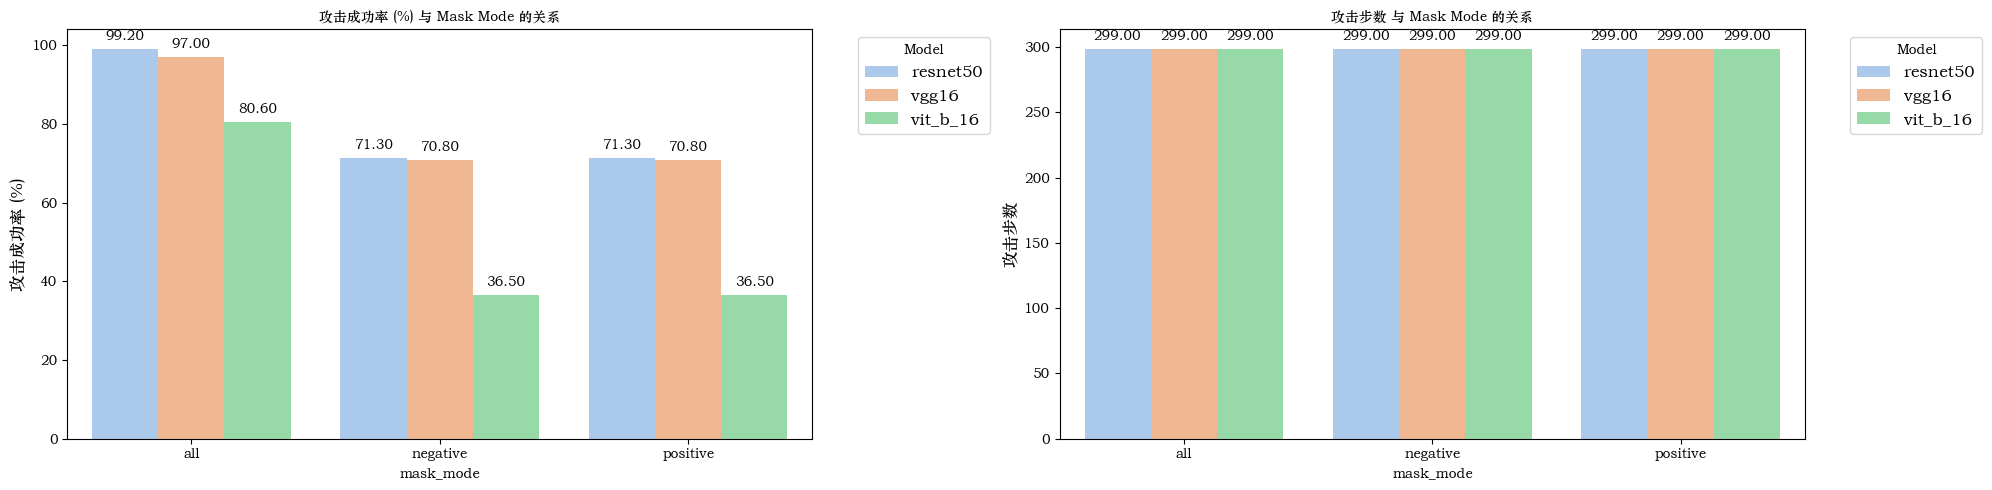

In [6]:
plot_success_rate_vs_mask_mode(data_result, output_path=data_root, save_name='success_rate_vs_mask_mode')

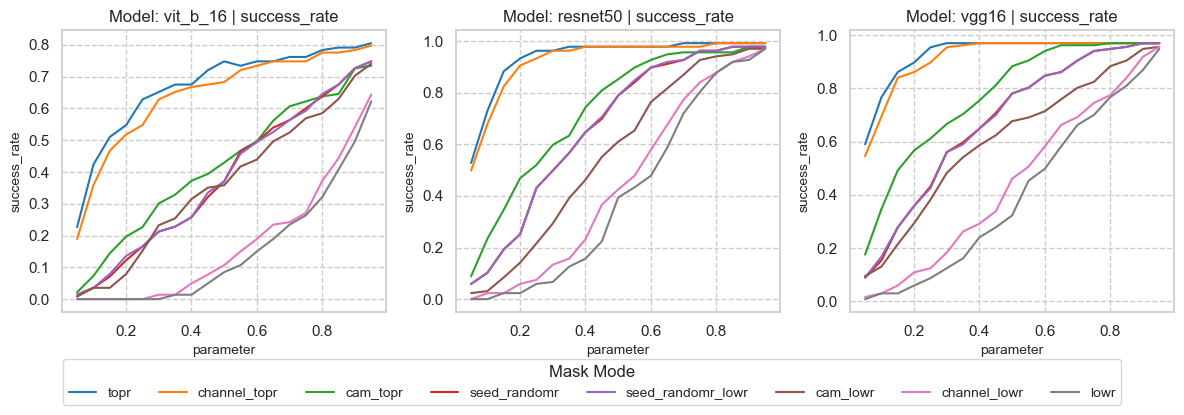

In [7]:
# label_list = ['success_rate', 'attack_loss']
label_list = ['success_rate']
mask_mode_list = ['topr', 'channel_topr', 'cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr']
plot_success_rate_vs_r(data_result, var = 'parameter', label_list = label_list, output_path=data_root, save_name='multi_only_success_rate_vs_parameter', ncols=3, nrows=1, mask_mode_list=mask_mode_list)

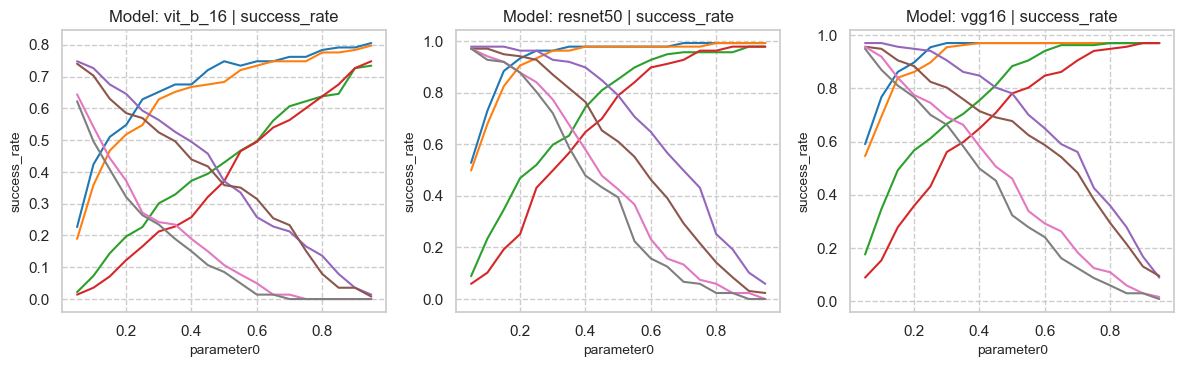

In [ ]:
label_list = ['success_rate']
plot_success_rate_vs_r(data_result, var = 'parameter0', label_list = label_list, output_path=data_root, save_name='success_rate_vs_parameter0', ncols=3, nrows=1, mask_mode_list=mask_mode_list,if_legend=False)    

## 完整数据，查看攻击每一步的过程中指标的变化

In [34]:
data_all = pd.read_excel('./data_stage3/multi_step_total100_1016/result_multi_step_total100_1016.xlsx')
data_all.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,vit_b_16,i_fgsm,0.0001,all,0,-1.0,0.01,161.1113,0.054537,0.129736,0.129736,0.0,210.673,100,-1.0
1,vit_b_16,i_fgsm,0.0001,all,1,-1.0,0.01,168.1469,0.045632,0.137750,0.137985,0.0,210.673,100,-1.0
2,vit_b_16,i_fgsm,0.0001,all,2,-1.0,0.01,182.6081,0.078490,0.146638,0.146942,0.0,210.673,100,-1.0
3,vit_b_16,i_fgsm,0.0001,all,3,-1.0,0.01,187.4057,0.049670,0.155498,0.157145,0.0,210.673,100,-1.0
4,vit_b_16,i_fgsm,0.0001,all,4,-1.0,0.01,197.0542,0.054358,0.164775,0.168450,0.0,210.673,100,-1.0


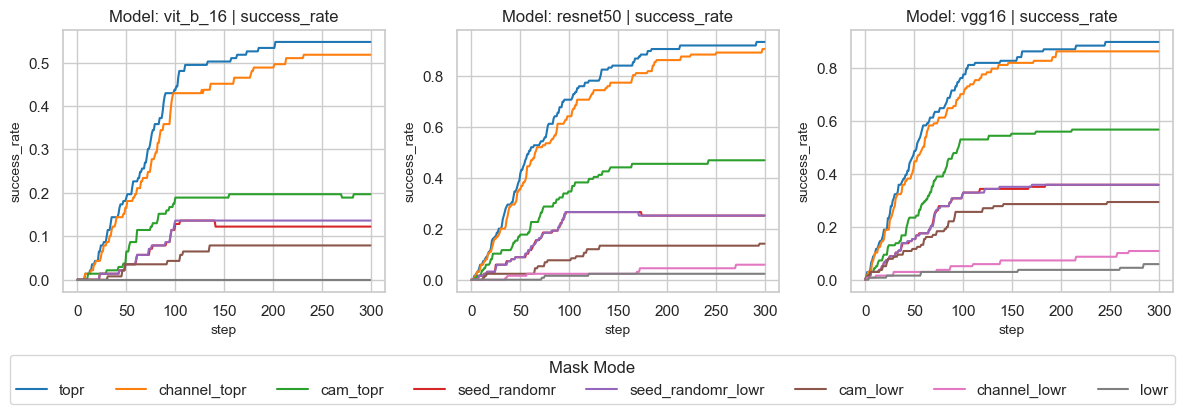

In [49]:
label_list = ['success_rate']
r = 0.2
mask_mode_list = ['topr', 'channel_topr', 'cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr']
plot_success_rate_vs_step(data_all, r, 'step', label_list, output_path=data_root, save_name=f'r={r}_success_rate_vs_step', ncols=3, nrows=1, suptitle=f'r = {r}: Success Rate vs. Step', mask_mode_list=mask_mode_list)

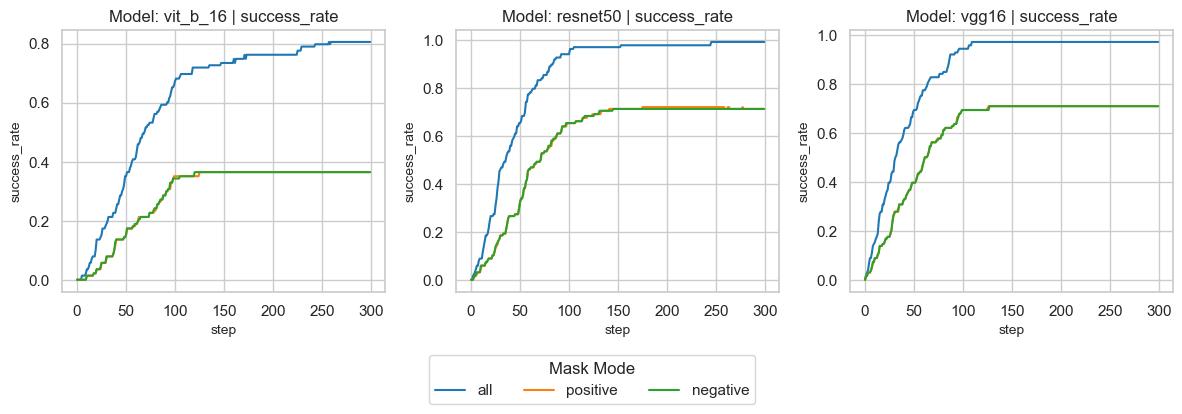

In [50]:
label_list = ['success_rate']
r = -1
mask_mode_list = ['all', 'positive', 'negative']
plot_success_rate_vs_step(data_all, r, 'step', label_list, output_path=data_root, save_name=f'r={r}_success_rate_vs_step', ncols=3, nrows=1, suptitle=f'r = {r}: Success Rate vs. Step', mask_mode_list=mask_mode_list)

# 画出pred_loss和attack_loss的散点图

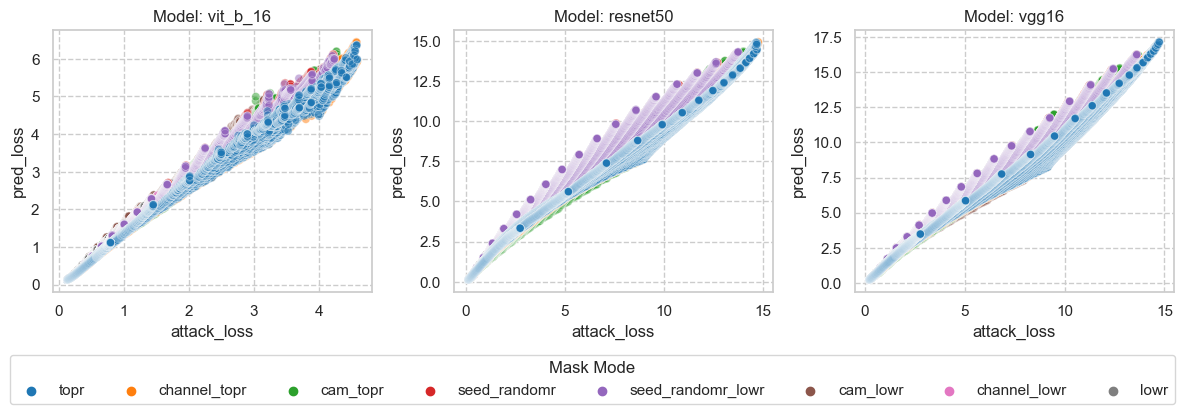

In [33]:
plot_loss_vs_pred_loss(data_all, output_path=data_root, save_name='loss_vs_pred_loss',mask_mode_list = mask_mode_list)

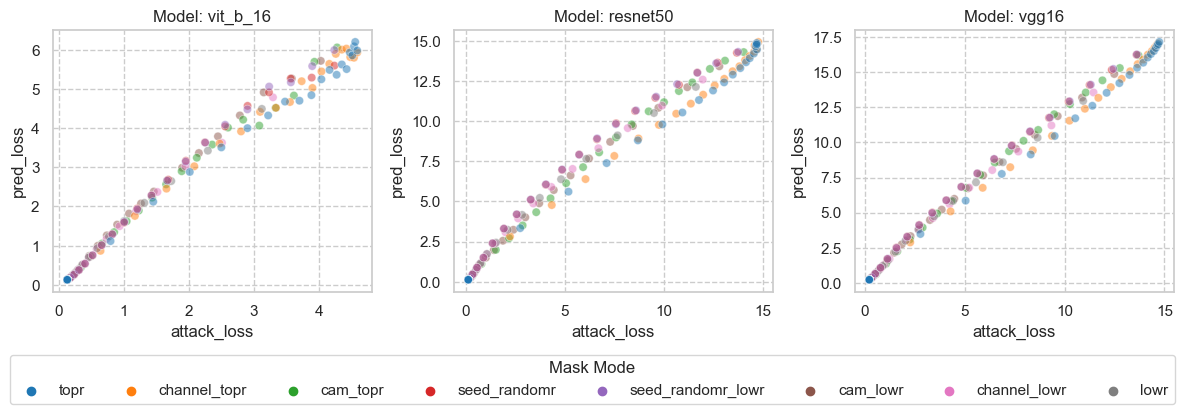

In [32]:
plot_loss_vs_pred_loss(data_result, output_path=data_root, save_name='filtered_loss_vs_pred_loss', mask_mode_list = mask_mode_list)